In [1]:
from utils.utils import _norm_numpy, _similarity, _top_k_index
import torch
import numpy as np
from PIL import Image
from typing import List
import torchvision.transforms as T
from metrics.metrics import BasicMetrics, Accuracy
from torch.utils.data import DataLoader
from model.keras.torch_keras import Model
from data.LmdbDataSet import TripleDataSet
from model.model import TripleNormalizationIDClassificationFeature
from model.feature.efficient_net import efficient_net_b4
from loss.loss_layer import CrossEntropyLoss, BatchHardTripletLoss, BasicLoss, LabelSmoothingCrossEntropy

C:\Users\zhangluoyang\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\zhangluoyang\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\zhangluoyang\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\zhangluoyang\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
test_data_dir = r"G:/group_image/test"

In [4]:
transform = T.Compose([T.Resize((224, 224), interpolation=Image.BICUBIC),
                           T.ToTensor()])

In [5]:
test_db_path = "{0}/data.db".format(test_data_dir)
test_keys_path = "{0}/keys.npy".format(test_data_dir)
test_zone_index_path = "{0}/zone_index.json".format(test_data_dir)
test_data_set = TripleDataSet(db_path=test_db_path, keys_path=test_keys_path,
                              zone_index_path=test_zone_index_path, transform=transform)

##  加载模型

In [6]:
# 类别分类样本数目 (一万类别哈....具体根据数据来定夺)
class_num = 10000
# 特征提取层的特征维度
in_features = 1792
batch_size = 8
num_workers = 4
epochs: int = 200
check_path: str = "./check_point"
log_step_freq: int = 1
device: str = "cuda:1"
# dataSet 输出的tensor 名称
tensor_names: List[str] = ["target_image",
                           "positive_image",
                           "negative_image",
                           "target",
                           "positive_weight",
                           "negative_weight"]
# 损失函数 (分类的损失函数适当小一些 类目太多)
# classification_loss = CrossEntropyLoss(tensor_name="out", target_tensor_name="target", eof=0.2)
classification_loss = LabelSmoothingCrossEntropy(tensor_name="out", target_tensor_name="target", eof=0.2, alpha=0.1)
triple_loss = BatchHardTripletLoss(target_feature_tensor_name="feature",
                                   positive_feature_tensor_name="positive_feature",
                                   positive_weight_tensor_name="positive_weight",
                                   negative_feature_tensor_name="negative_feature",
                                   negative_weight_tensor_name="negative_weight",
                                   eof=1.0)
loss_funcs: List[BasicLoss] = [classification_loss, triple_loss]
# 评估函数
metrics_funcs: List[BasicMetrics] = [Accuracy(tensor_names=["out", "target"])]
# 特征提取器
feature_net = efficient_net_b4()

In [7]:
triple_net = TripleNormalizationIDClassificationFeature(feature_module=feature_net,
                                                            in_features=in_features,
                                                            class_num=class_num,
                                                            bias=False)

In [8]:
state_dict = torch.load(r'C:/Users/zhangluoyang/Desktop/best.pth', map_location={'cuda:1':'cuda:0'})

In [9]:
triple_net.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [10]:
triple_net = triple_net.eval()

In [11]:
from tqdm import tqdm

In [38]:
keys = test_data_set.keys

In [50]:
# 找出所有的睡眠区
new_keys = []
for key in keys:
    target_data = test_data_set.get_value_by_key(key=key)
    zone_id = target_data['groupPictureLabelData']["zoneId"]
    if zone_id == 48:
        new_keys.append(key)

In [52]:
test_data_set.keys = np.array(new_keys)

In [83]:
length = len(test_data_set)
images = []
features = []
for i in tqdm(range(length)):
    target_image, positive_image, negative_image, target, positive_weight, negative_weight = test_data_set.__getitem__(i)
    target_feature = triple_net.feature_extractor(target_image.unsqueeze(dim=0))
    positive_feature = triple_net.feature_extractor(positive_image.unsqueeze(dim=0))
    negative_feature = triple_net.feature_extractor(negative_image.unsqueeze(dim=0))
    target_image = np.transpose(target_image.tolist(), axes=(1, 2, 0))
    positive_image = np.transpose(positive_image.tolist(), axes=(1, 2, 0))
    negative_image = np.transpose(negative_image.tolist(), axes=(1, 2, 0))
    images.append(target_image)
    images.append(positive_image)
    images.append(negative_image)
    features.append(target_feature.tolist())
    features.append(positive_feature.tolist())
    features.append(negative_feature.tolist())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 582/582 [07:26<00:00,  1.30it/s]


In [84]:
from utils.utils import calculate_euclidean_distance

In [145]:
distance = calculate_euclidean_distance([features[55]], features)

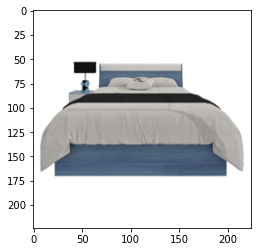

In [146]:
plt.imshow(images[55])

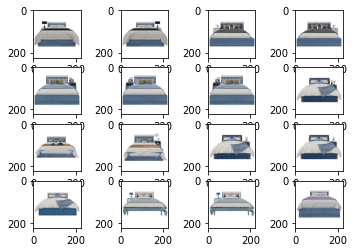

In [147]:
sim_topk = np.argsort(distance)[: 16]
plt.figure()
for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.imshow(images[sim_topk[i - 1]])
plt.show()

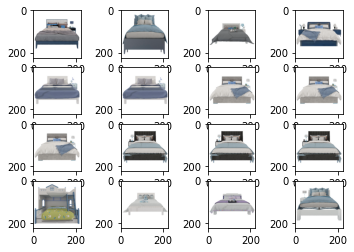

In [148]:
no_sim_topk = np.argsort(distance)[200: 216]
plt.figure()
for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.imshow(images[no_sim_topk[i - 1]])
plt.show()